# **Bayesian and Gaussian Process regression**

    Notebook version: 1.0 (Oct 16, 2015)

    Authors: Miguel Lázaro Gredilla
             Jerónimo Arenas García (jarenas@tsc.uc3m.es)

    Changes: v.1.0 - First version. Python version
    
    Pending changes: 

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lng
import scipy.io       # To read matlab files
from scipy import spatial
import pylab
pylab.rcParams['figure.figsize'] = 10, 5

# 1. Introduction

In this exercise the student will review several key concepts of Bayesian regression and Gaussian processes.

For the purpose of this exercise, the regression model is

$${s}({\bf x}) = f({\bf x}) + \varepsilon$$

where ${s}({\bf x})$ is the output corresponding to input ${\bf x}$, $f({\bf x})$ is the unobservable latent function, and $\varepsilon$ is white zero-mean Gaussian noise, i.e., $\varepsilon \sim {\cal N}(0,\sigma_\varepsilon^2)$.


### Practical considerations

   - Though sometimes unavoidable, it is recommended not to use explicit matrix inversion whenever possible. For instance, if an operation like ${\mathbf A}^{-1} {\mathbf b}$ must be performed, it is preferable to code it using python $\mbox{numpy.linalg.lstsq}$ function (see http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html), which provides the LS solution to the overdetermined system ${\mathbf A} {\mathbf w} = {\mathbf b}$.
   
   - Sometimes, the computation of $\log|{\mathbf A}|$ (where ${\mathbf A}$ is a positive definite matrix) can overflow available precision, producing incorrect results. A numerically more stable alternative, providing the same result is $2\sum_i \log([{\mathbf L}]_{ii})$, where $\mathbf L$ is the Cholesky decomposition of $\mathbf A$ (i.e., ${\mathbf A} = {\mathbf L}^\top {\mathbf L}$), and $[{\mathbf L}]_{ii}$ is the $i$th element of the diagonal of ${\mathbf L}$.
   
   - Non-degenerate covariance matrices, such as the ones in this exercise, are always positive definite. It may happen, as a consequence of chained rounding errors, that a matrix which was mathematically expected to be positive definite, turns out not to be so. This implies its Cholesky decomposition will not be available. A quick way to palliate this problem is by adding a small number (such as $10^{-6}$) to the diagonal of such matrix.

### Reproducibility of computations

To guarantee the exact reproducibility of the experiments, it may be useful to start your code initializing the seed of the random numbers generator, so that you can compare your results with the ones given in this notebook.

In [2]:
np.random.seed(3)

# 2. Bayesian regression with a linear model

During this section, we will assume the following parametric model for the latent function

$$f({\bf x}) = {\bf x}^\top {\bf w}$$

i.e., a linear model in the observations, where ${\bf w}$ contains the parameters of the model. The <i>a priori</i> distribution of ${\bf w}$ is assumed to be

$${\bf w} \sim {\cal N}({\bf 0}, \sigma_0^2~{\bf I})$$

## 2.1. Synthetic data generation

First, we are going to generate synthetic data (so that we have the ground-truth model) and use them to make sure everything works correctly and our estimations are sensible.

Set parameters $\sigma_0^2 = 2$ and $\sigma_{\varepsilon}^2 = 0.2$. Generate a weight vector $\mbox{true_w}$ with two elements from the <i>a priori</i> distribution of the weights. This vector determines the regression line that we want to find (i.e., the optimum unknown solution).

Generate an input matrix $\mbox{X}$ containing the constant term 1 in all elements of the first column and values between 0 and 2 (included), with a 0.1 step, in the second column.

Finally, generate the output vector ${\mbox s}$ as the product $\mbox{X} \ast \mbox{true_w}$ plus Gaussian noise of pdf ${\cal N}(0,\sigma_\varepsilon^2)$ at each element.

Plot the generated data. You will notice a linear behavior, but the presence of noise makes it hard to estimate precisely the original straight line that generated them (which is stored in $\mbox{true_w}$).

[[ 2.  0.]
 [ 0.  2.]]
Valor de true_w:
[[ 2.52950265]
 [ 0.61731815]]
Valor de X:
[[ 1.   0. ]
 [ 1.   0.1]
 [ 1.   0.2]
 [ 1.   0.3]
 [ 1.   0.4]
 [ 1.   0.5]
 [ 1.   0.6]
 [ 1.   0.7]
 [ 1.   0.8]
 [ 1.   0.9]
 [ 1.   1. ]
 [ 1.   1.1]
 [ 1.   1.2]
 [ 1.   1.3]
 [ 1.   1.4]
 [ 1.   1.5]
 [ 1.   1.6]
 [ 1.   1.7]
 [ 1.   1.8]
 [ 1.   1.9]
 [ 1.   2. ]]
Valor de s:
[[ 2.57265762]
 [ 1.75785519]
 [ 2.5289145 ]
 [ 2.55604505]
 [ 2.73942679]
 [ 2.55775849]
 [ 2.88029745]
 [ 2.74820696]
 [ 2.43577899]
 [ 3.48070414]
 [ 3.54095821]
 [ 3.97309693]
 [ 3.29266015]
 [ 3.151039  ]
 [ 3.14985567]
 [ 2.76387419]
 [ 3.95653976]
 [ 3.08653109]
 [ 3.1107064 ]
 [ 3.6104377 ]
 [ 4.4287647 ]]


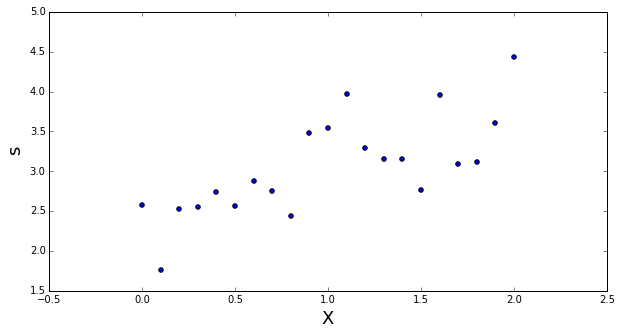

In [3]:
# Parameter settings
sigma_0 = np.sqrt(2)
sigma_eps = np.sqrt(0.2)

cov_m = sigma_0**2 * np.eye(2)
print cov_m

#Optimum solution
true_w = np.random.multivariate_normal(np.zeros(2), cov_m)
true_w = true_w[:, np.newaxis] # de 2x1

print "Valor de true_w:\n", str(true_w)
#true_w = np.random.normal(loc=0.0, scale=sigma_0, size=2)
#print(true_w) #Debe dar esto: 2.52950265  0.61731815

#Training datapoints
####################################
##### Fill in your code here #######
####################################

X = np.array([np.ones(21) , np.linspace(0,2,21)], dtype = float)
print "Valor de X:\n", str(X.T)

# Generamos true_w * x + ruido
cov_ruido = sigma_eps**2 * np.eye(21)
ruido = np.random.multivariate_normal(np.zeros(21), cov_ruido)
ruido = ruido[:,np.newaxis]

s = np.dot(X.T, true_w) + ruido # de 21x1
print "Valor de s:\n", str(s)

#Plot training points
plt.figure()
ax1 = plt.subplot(111)

ax1.scatter(X[1,:],s)
plt.xlabel('X', fontsize=18)
plt.ylabel('s', fontsize=18)

## 2.2. Posterior pdf of the weight vector

Let us see to which extent it is possible to determine the original straight line from observed data. Knowing that the generative model is linear (i.e., $f({\bf x}) = {\bf x}^\top{\bf w}$, and knowing also the prior pdf of weights $p({\bf w}) = {\cal N}({\bf 0},\sigma_0^2~{\bf I})$ and noise $p(\varepsilon) = {\cal N}(0,\sigma_\varepsilon^2)$, compute the posterior pdf of the weights, $p({\bf w}\mid{\bf s})$.

In [4]:
Cov_w = np.linalg.inv((np.dot(X,X.T)/sigma_eps**2) + np.linalg.inv(cov_m)) 
mean_w = sigma_eps**(-2) * np.dot(np.dot(Cov_w, X), s).T #de 2x1
mean_w = np.array(mean_w).flatten() # para que tenga dimension 1

# VALORES QUE DEBERIAN SALIR:
# true_w = [ 2.52950265  0.61731815]
# mean_w = [ 2.29909556  0.75291393]
# Cov_w = [[ 0.03455724 -0.02519798]
#  [-0.02519798  0.02531797]]

The results is:

In [5]:
print 'true_w = ' + str(true_w)
print 'mean_w = ' + str(mean_w)
print 'Cov_w = ' + str(Cov_w)

true_w = [[ 2.52950265]
 [ 0.61731815]]
mean_w = [ 2.29909556  0.75291393]
Cov_w = [[ 0.03455724 -0.02519798]
 [-0.02519798  0.02531797]]


## 2.3. Sampling regression curves from the posterior

Plot now the functions corresponding to different samples drawn from the posterior distribution of the weight vector. To this end, generate random vectors ${\bf w}_l$ with $l = 1,\dots, 50$, from the posterior density of the weights, $p({\bf w}\mid{\bf s})$, and use them to generate 50 straight lines, $f({\bf x}^\ast) = {{\bf x}^\ast}^\top {\bf w}_l$, with the second component of ${\bf x}^\ast$ between $-1$ and $3$, with step $0.1$.

Plot the original ground-truth straight line, corresponding to $\mbox{true_w}$, along with the $50$ generated straight lines and the original samples, all in the same plot. As you can check, the Bayesian model is not providing a single answer, but instead a density over them, from which we have extracted 50 options.

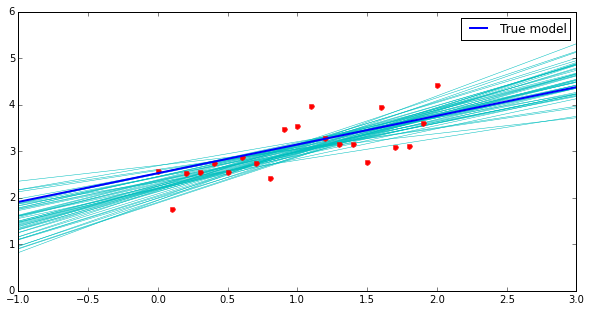

In [6]:
# 50 rectas de color cyan
w_l = np.random.multivariate_normal(mean_w, Cov_w, 50).T

# rango de x entre -1 y 3. Da lugar a 50 rectas con 41 muestras.
X_l = np.array([np.ones(41), np.linspace(-1,3,41)])

f = np.dot(X_l.T, w_l) 

# Carga de la figura y el plot
plt.figure()
ax2 = plt.subplot(111)

# Representacion de las rectas
for i in range(0,50):
    ax2.plot(X_l[1,:], f[:,i], 'c-', linewidth=0.5)

# Representacion de la grafica anterior del 2.2.
ax2.plot(X[1,:], s, 'r.', markersize=10)

# Representacion de true_w
true_f = np.dot(X_l.T, true_w)
ax2.plot(X_l[1,:], true_f, 'b-', label='True model', linewidth=2)
ax2.legend(loc="best")

## 2.4. Plotting the confidence intervals

On top of the previous figure (copy here your code from the previous section), plot functions

$${\mathbb E}\left\{f({\bf x}^\ast)\mid{\bf s}\right\}$$

and

$${\mathbb E}\left\{f({\bf x}^\ast)\mid{\bf s}\right\} \pm 2 \sqrt{{\mathbb V}\left\{f({\bf x}^\ast)\mid{\bf s}\right\}}$$

(i.e., the posterior mean of $f({\bf x}^\ast)$, as well as two standard deviations above and below).

It is possible to show analytically that this region comprises $95.45\%$ probability of the posterior probability $p(f({\bf x}^\ast)\mid {\bf s})$ at each ${\bf x}^\ast$.

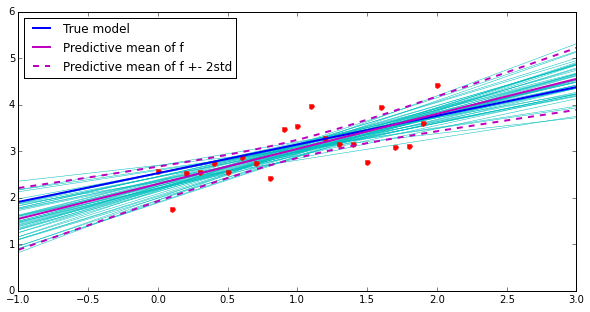

In [7]:
plt.figure()
ax3 = plt.subplot(111)

# Representacion de las rectas
for i in range(0,50):
    ax3.plot(X_l[1,:], f[:,i], 'c-', linewidth=0.5)
    
# Representacion de lo anterior
ax3.plot(X[1,:], s, 'r.', markersize=10)

# Representacion de true_w
true_f = np.dot(X_l.T, true_w)
ax3.plot(X_l[1,:], true_f, 'b-', label='True model', linewidth=2)

#####################################################
# Queremos representar:                             #
#       E { f(x*) | s }                             #
#       E { f(x*) | s } +- 2 sqrt( V { f(x*) | s }) #
#####################################################
#
## cálculo de la media y la varianza de f(x*)
#
# Forma práctica:
#
#E_f = np.mean(f, axis = 1)
#V_f = np.std(f, axis = 1)

E_f = X_l.T.dot(Cov_w).dot(X).dot(s)/(sigma_eps**2)
V_f = []

for c in range(0,41):
    V_f.append(X_l[:,c].dot(Cov_w).dot(X_l[:,c].T))

V_f = np.array(V_f)
V_f = V_f[:, np.newaxis]

EV_f_pos = E_f + 2 * np.sqrt(V_f)
EV_f_neg = E_f - 2 * np.sqrt(V_f)

# Representacion grafica:

ax3.plot(X_l[1,:], E_f, 'm-', label='Predictive mean of f', linewidth=2)
ax3.plot(X_l[1,:], EV_f_pos, 'm--', label='Predictive mean of f +- 2std', linewidth=2)
ax3.plot(X_l[1,:], EV_f_neg, 'm--', linewidth=2)
ax3.legend(loc="best")

Plot now ${\mathbb E}\left\{s({\bf x}^\ast)\mid{\bf s}\right\} \pm 2 \sqrt{{\mathbb V}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}}$ (note that the posterior means of $f({\bf x}^\ast)$ and $s({\bf x}^\ast)$ are the same, so there is no need to plot it again). Notice that $95.45\%$ of observed data lie now within the newly designated region. These new limits establish a confidence range for our predictions. See how the uncertainty grows as we move away from the interpolation region to the extrapolation areas.

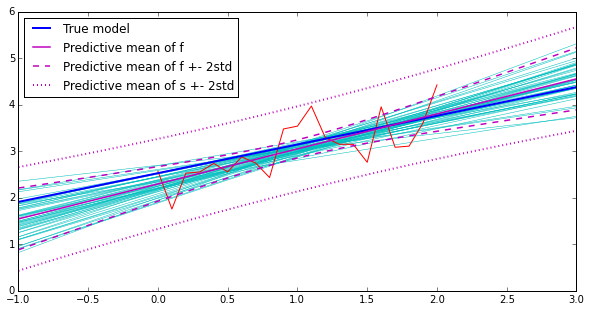

In [8]:
plt.figure()
ax4 = plt.subplot(111)

# Representacion de las rectas
for i in range(0,50):
    ax4.plot(X_l[1,:], f[:,i], 'c-', linewidth=0.5)

# Representacion de los datos
ax4.plot(X[1,:], s, 'r-', markersize=10)

# Representacion de true_w
true_f = np.dot(X_l.T, true_w)
ax4.plot(X_l[1,:], true_f, 'b-', label='True model', linewidth=2)

#####################################################
# Queremos representar:                             #
#       E { f(x*) | s }                             #
#       E { f(x*) | s } +- 2 sqrt( V { f(x*) | s }) #
#       E { s(x*) | s }                             #
#       E { s(x*) | s } +- 2 sqrt( V { s(x*) | s }) #
#####################################################
#
## cálculo de la media y la varianza de f(x*)
#
# Forma práctica:
#
#E_f = np.mean(f, axis = 1)
#V_f = np.std(f, axis = 1)


# Forma teórica:

E_f = X_l.T.dot(Cov_w).dot(X).dot(s)/(sigma_eps**2)

V_f = []

for c in range(0,41):
    V_f.append(X_l[:,c].dot(Cov_w).dot(X_l[:,c].T))
    
V_f = np.array(V_f)
V_f = V_f[:, np.newaxis]

EV_f_pos = E_f + 2 * np.sqrt(V_f)
EV_f_neg = E_f - 2 * np.sqrt(V_f)

# Calculo de las rectas para s(x*)
V_s = V_f + sigma_eps**2
sigma_s = np.sqrt(V_s)

EV_s_pos = E_f + 2 * sigma_s
EV_s_neg = E_f - 2 * sigma_s

# Representacion grafica
ax4.plot(X_l[1,:], E_f, 'm-', label='Predictive mean of f', linewidth=1.5)
ax4.plot(X_l[1,:], EV_f_pos, 'm--', label='Predictive mean of f +- 2std', linewidth=1.5)
ax4.plot(X_l[1,:], EV_f_neg, 'm--', linewidth=1.5)
ax4.plot(X_l[1,:], EV_s_pos, 'm:', label='Predictive mean of s +- 2std', linewidth=2)
ax4.plot(X_l[1,:], EV_s_neg, 'm:', linewidth=2)
ax4.legend(loc="best")


# 3. Non-linear regression with Gaussian Processes

## 3.1. Multidimensional regression

Rather than using a parametric form for $f({\mathbf x})$, in this section we will use directly the values of the latent function that we will model with a Gaussian process

$$f({\mathbf x}) \sim {\cal GP}\left(0,k_f({\mathbf x}_i,{\mathbf x}_j)\right),$$

where we are assuming a zero mean, and where we will use the Ornstein-Uhlenbeck covariance function, which is defined as:

$$k_f({\mathbf x}_i,{\mathbf x}_j) = \sigma_0^2 \exp \left( -\frac{1}{l}\|{\mathbf x}_i-{\mathbf x}_j\|\right)$$

First, we will use the following gross estimation for the hyperparameters:

In [20]:
sigma_0 = np.std(Ytrain)
sigma_eps = sigma_0 / np.sqrt(10)
l = 8

As we studied in a previous session, the joint distribution of the target values in the training set, ${\mathbf s}$, and the latent values corresponding to the test points, ${\mathbf f}^\ast$, is given by

$$\left[\begin{array}{c}{\bf s}\\{\bf f}^\ast\end{array}\right]~\sim~{\cal N}\left({\bf 0},\left[\begin{array}{cc}{\bf K} + \sigma_\varepsilon^2 {\bf I}& {\bf K}_\ast^\top \\ {\bf K}_\ast & {\bf K}_{\ast\ast} \end{array}\right]\right)$$

Using this model, obtain the posterior of ${\mathbf s}^\ast$ given ${\mathbf s}$. In particular, calculate the <i>a posteriori</i> predictive mean and standard deviations, ${\mathbb E}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}$ and $\sqrt{{\mathbb V}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}}$ for each test sample ${\bf x}^\ast$.

Obtain the MSE and NLPD and compare them with those obtained Subsection 3.3.

In [23]:
dist = spatial.distance.cdist(Xtrain_e, Xtrain_e)
dist_ss = spatial.distance.cdist(Xtest_e, Xtest_e)
dist_s = spatial.distance.cdist(Xtest_e, Xtrain_e)

K = sigma_0**2 * np.exp(-dist/l)
K_ss = sigma_0**2 * np.exp(-dist_ss/l)
K_s = sigma_0**2 * np.exp(-dist_s/l)

You should obtain the following results:

In [24]:
print 'MSE = ' + str(MSE)
print 'NLPD = ' + str(NLPD)

MSE = 6.11353618976
NLPD = 1.33761732312


## 3.2. Unidimensional regression

Use now only the first company to compute the non-linear regression. Obtain the posterior
distribution of $f({\mathbf x}^\ast)$ evaluated at the test values ${\mathbf x}^\ast$, i.e, $p(f({\mathbf x}^\ast)\mid {\mathbf s})$.

This distribution is Gaussian, with mean ${\mathbb E}\left\{f({\bf x}^\ast)\mid{\bf s}\right\}$ and a covariance matrix $\text{Cov}\left[f({\bf x}^\ast)\mid{\bf s}\right]$. Sample 50 random vectors from the distribution and plot them vs. the values $x^\ast$, together with the test samples.

These 50 samples of the function space are analogous to the 50 straight lines that were generated in Subsection 2.3. Again, the Bayesian model does not provide a single function, but a pdf over functions, from which we extracted 50 possible functions.

In [26]:
m_gp = K_s.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(Xtrain.shape[0]))).dot(Ytrain)
Cov_gp = K_ss - K_s.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(Xtrain.shape[0]))).dot(K_s.T)

In [27]:
v_gp = np.diagonal(Cov_gp) + sigma_eps**2

In [28]:
MSE_gp = np.mean((m_gp - Ytest)**2)

In [30]:
NLPD_gp = 0.5 * np.mean(((Ytest - m_gp)**2)/(np.matrix(v_gp).T) + 0.5*np.log(2*pi*np.matrix(v_gp).T))

Compute now the MSE and NLPD of the model. The correct results are given below:

In [32]:
print 'MSE = ' + str(MSE_gp)
print 'NLPD = ' + str(NLPD_gp)

MSE = 0.494826685646
NLPD = 0.967323914258
